In [2]:
import google.auth
from google.cloud import bigquery


credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bq = bigquery.Client(credentials=credentials, project=your_project_id,)


In [134]:
#query for big query public dataset for newyork yellow taxi trips for 2018
query_string="""
select *, ABS(FARM_FINGERPRINT(CAST(pickup_datetime as STRING))) as trip_id,
ST_X(ST_GEOGPOINTFROMGEOHASH(pickup_location_id)) as pickup_longitude, 
ST_Y(ST_GEOGPOINTFROMGEOHASH(pickup_location_id)) as pickup_latitude, 
ST_X(ST_GEOGPOINTFROMGEOHASH(dropoff_location_id)) as dropoff_longitude, 
ST_Y(ST_GEOGPOINTFROMGEOHASH(dropoff_location_id)) as dropoff_latitude 
from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`  where  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000)= 1
"""


#query_string="select *, ST_X(ST_GEOGPOINTFROMGEOHASH(pickup_location_id)) as pickup_longitude, ST_Y(ST_GEOGPOINTFROMGEOHASH(pickup_location_id)) as pickup_latitude, ST_X(ST_GEOGPOINTFROMGEOHASH(dropoff_location_id)) as dropoff_longitude, ST_Y(ST_GEOGPOINTFROMGEOHASH(dropoff_location_id)) as dropoff_latitude from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`  where  MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000)= 1"
#trips = bq.query(query_string).to_dataframe()

In [137]:
query="""
select *, ABS(FARM_FINGERPRINT(CAST(pickup_datetime as STRING))) as trip_id,
from `bigquery-public-data.new_york.tlc_yellow_trips_2016` where  
  ((pickup_latitude BETWEEN -90 AND 90) AND
  (pickup_longitude BETWEEN -180 AND 180)) 
AND
  ((dropoff_latitude BETWEEN -90 AND 90) AND
  (dropoff_longitude BETWEEN -180 AND 180))
  
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000)= 1
"""
trips = bq.query(query).to_dataframe()

In [139]:
trips.head(n=5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,trip_id
0,2,2016-03-14 04:01:07+00:00,2016-03-14 04:19:48+00:00,5,10.28,-73.980522,40.763897,1,N,-73.872925,40.774487,1,29.0,0.5,0.5,7.17,5.54,0.3,43.01,1605794924106095001
1,2,2016-06-08 14:44:44+00:00,2016-06-08 15:37:07+00:00,1,6.64,-74.004700,40.707081,1,N,-73.979309,40.764481,1,32.0,0.0,0.5,6.56,0.00,0.3,39.36,225664834480260001
2,1,2016-06-15 12:38:11+00:00,2016-06-15 13:22:34+00:00,2,14.80,-73.782043,40.644447,1,N,-73.925301,40.765335,1,48.0,0.0,0.5,7.00,0.00,0.3,55.80,628951059384615001
3,2,2016-02-18 20:28:20+00:00,2016-02-18 21:02:50+00:00,2,8.94,-73.984718,40.758476,1,N,-73.856377,40.730083,1,32.0,0.5,0.5,6.66,0.00,0.3,39.96,9209303918194510001
4,1,2016-06-06 02:44:50+00:00,2016-06-06 02:58:50+00:00,1,7.00,-73.971588,40.762749,1,N,-73.938339,40.824646,1,22.0,0.5,0.5,4.65,0.00,0.3,27.95,619585738286910001


In [140]:
trips.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'imp_surcharge', 'total_amount', 'trip_id'],
      dtype='object')

In [141]:
#creating desired feature vector
feature_cols=['vendor_id','trip_id','pickup_datetime','passenger_count','trip_distance', 'rate_code', 'store_and_fwd_flag', 'fare_amount', 'extra', 'tolls_amount','imp_surcharge', 'total_amount','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude']
feature_df = trips[feature_cols]
feature_df.head()

,vendor_id,trip_id,pickup_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,fare_amount,extra,tolls_amount,imp_surcharge,total_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2,1605794924106095001,2016-03-14 04:01:07+00:00,5,10.28,1,N,29.0,0.5,5.54,0.3,43.01,-73.980522,40.763897,-73.872925,40.774487
1,2,225664834480260001,2016-06-08 14:44:44+00:00,1,6.64,1,N,32.0,0.0,0.00,0.3,39.36,-74.004700,40.707081,-73.979309,40.764481
2,1,628951059384615001,2016-06-15 12:38:11+00:00,2,14.80,1,N,48.0,0.0,0.00,0.3,55.80,-73.782043,40.644447,-73.925301,40.765335
3,2,9209303918194510001,2016-02-18 20:28:20+00:00,2,8.94,1,N,32.0,0.5,0.00,0.3,39.96,-73.984718,40.758476,-73.856377,40.730083
4,1,619585738286910001,2016-06-06 02:44:50+00:00,1,7.00,1,N,22.0,0.5,0.00,0.3,27.95,-73.971588,40.762749,-73.938339,40.824646


In [142]:
feature_df['trip_distance'] = feature_df['trip_distance'].astype(float)
feature_df['fare_amount'] = feature_df['fare_amount'].astype(float)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

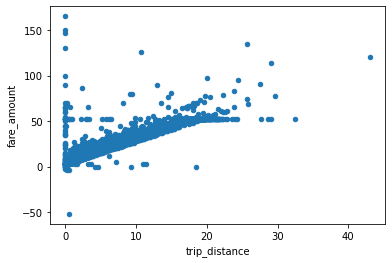

In [143]:
feature_df.plot.scatter(x='trip_distance',y='fare_amount')
#feature_df.plot.scatter(x='trip_distance',y='fare_amount', s='fare_amount')

In [144]:
from google.cloud import storage
gcs = storage.Client()
bucket = gcs.get_bucket('red-beryl-staging-bucket')
#delete old uploads, not a efficient way
blobs = bucket.list_blobs(prefix='upload')
for blob in blobs:
  blob.delete()

bucket.blob('upload/nyc_taxi_trips_2018.csv').upload_from_string(feature_df.to_csv(), 'text/csv')

In [145]:
#create a bigquery dataset
dataset_id="redbq"
table="redbq.nyc_taxi_trips"


reference = bq.dataset(dataset_id)
dataset = bq.get_dataset(reference)
print(dataset)
job_config = bigquery.job.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = bq.load_table_from_dataframe(feature_df, table, job_config=job_config)

job.result()

# Create BigQuery dataset
#if not dataset.exists():
    #dataset.create()
print('Loaded {} rows into {}:{}.'.format(
        job.output_rows, dataset_id, table))


Dataset(DatasetReference('red-beryl-labs', 'redbq'))
Loaded 13729 rows into redbq:redbq.nyc_taxi_trips.


,fare_amount,dayofweek,hourofday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
